In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import ot
from scipy.spatial.distance import cdist

from scipy.stats import multivariate_normal as mvn
from matplotlib import cm

In [2]:
# from sklearn.datasets import fetch_openml

# # Load MNIST dataset using scikit-learn
# mnist = fetch_openml('mnist_784')

# # Extract features and labels
# images, labels = mnist.data, mnist.target

# np.save("PATH//mnist_data.npy", np.array(images.values))
# np.save("PATH//mnist_labels.npy", np.array(labels.values))

In [3]:
data_folder = 'D:\\MNIST-digits\\'

images = np.load(data_folder+"mnist_data.npy")
labels = np.load(data_folder+"mnist_labels.npy", allow_pickle=True)

image_list = [image.reshape(28,28) for i, image in enumerate(images) if labels[i] =='5']

In [4]:
class measure():
    
    def __init__(self, weights, locations):        
        self.weights = np.array(weights)
        self.locations = np.array(locations)
        
        #check that sizes are consistent
        assert self.weights.shape[0] == self.locations.shape[0]

        
        
        
    # Plotting #################################################################

    def plot_density(self):
        est = np.zeros((28,28))

        for i in range(28):
            for j in range(28):
                #Estimate measure on grid using Gaussian Kernels
                est[i,j] = np.sum(mvn.pdf(self.locations, mean=[i,j],cov=np.eye(2))*self.weights)

        plt.imshow(est, cmap=cm.hot_r)
        plt.xticks([])
        plt.yticks([])

    def plot_locations(self):
        # plt.plot(self.locations[self.weights>0,1], -self.locations[self.weights>0,0],'.',c='black', alpha = self.weights)
        for i, location in enumerate(self.locations):
            plt.plot(location[1], -location[0],'.',c='black', alpha = self.weights[i]/max(self.weights))
            
        plt.xlim(0,28)
        plt.ylim(-28,0)
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_aspect('equal', 'box')
        
def locations_update(barycenter, measure_list, Pi_list):
        
    return np.mean(np.array([measure_list[i].locations.T@Pi_list[i].T@np.diag(1/barycenter.weights.reshape(-1)) for i in range(len(measure_list))]),0).T


def weights_update(barycenter, alpha_list, lr=0.000075):
    
    #get subgradient
    alpha = np.mean(np.array(alpha_list),0)

    #calculate subgradient update
    a_star = barycenter.weights+(lr*alpha.reshape(1,-1))

    #project a_star into (interior of) probability simplex
    a_star[a_star<0]=0.000001
    a = a_star/np.sum(a_star)
    
    return a.reshape(-1)

    
def free_support_barycenter_update(measure_list, barycenter=None, N=20):
    
    if barycenter==None:
        init_weights = np.ones((N,1))/N
        init_locations = np.zeros(3)+np.random.normal(size=(N,3))
        barycenter = measure(init_weights, init_locations)
            
    else:
        
        M=np.square(cdist(barycenter.locations,measure_list[0].locations))
    
        result_list = [ot.emd(barycenter.weights,measure.weights,M,log=True) for measure in measure_list]
        Pi_list = [result[0] for result in result_list]
        alpha_list = [ot.lp.center_ot_dual(result[1]['u'],result[1]['v'])[0] for result in result_list]
        
        barycenter.locations = locations_update(barycenter, measure_list, Pi_list)
        barycenter.weights = weights_update(barycenter, alpha_list)
    
    return barycenter


In [5]:
#get distance matrix and coordinates for MNIST data
D = np.zeros((2,28,28))

for i in range(28):
    for j in range(28):
        
        D[:,i,j] = np.array([i,j])
        
coords = D.reshape(2,28*28).T

M = np.square(cdist(coords,coords))    

In [6]:
train_list=[]
test_list=[]
test_labels=[]

for i in range(10):
    image_list = [image.reshape(28,28) for i, image in enumerate(images[labels==str(i)])]
    train_list.append([measure((image/np.sum(image)).flatten(), coords) for image in image_list[:500] if np.sum(image)>0])
    test_list.append([measure((image/np.sum(image)).flatten(), coords) for image in image_list[500:] if np.sum(image)>0])
    test_labels = test_labels+list(np.ones(len(test_list[-1]))*i)
    
train_measure_list = np.concatenate(train_list)
test_measure_list = np.concatenate(test_list)

In [7]:
# N=200
# barycenter = measure(np.ones(N)/N, np.random.rand(N,2)*28)

# for i in range(10):
    
#     barycenter = free_support_barycenter_update(train_measure_list, barycenter, N=N)

# barycenter.plot_density()
# plt.show()
    

In [8]:
def get_decomp(barycenter, measure_list):
    
    wasserstein_distances=[]
    monge_distances=[]
    monge_wasserstein_distances=[]
    proj_distances=[]
    proj_wasserstein_distances=[]
    
    M0 = np.square(cdist(barycenter.locations, measure_list[0].locations))
    
    for i, measure in enumerate(measure_list):
        #
        D_x_y = np.square(cdist(barycenter.locations, measure.locations))
        gamma = ot.emd(barycenter.weights, measure.weights, D_x_y)
        Wasserstein_2_squared = np.sum(gamma*D_x_y)
        wasserstein_distances.append(Wasserstein_2_squared)
        
        nu_weights = np.sum(np.diag(1/barycenter.weights)@gamma,axis=1)
        D_x_Tx = np.square(cdist(barycenter.locations, np.diag(1/barycenter.weights)@gamma@measure.locations))

        Monge_2_squared = np.sum(np.diag(D_x_Tx)*barycenter.weights)
        monge_distances.append(Monge_2_squared)
        
        # #get $\nu \to T_\#\nu$ distances
        # M1 = np.square(cdist(barycenter.locations, np.diag(1/barycenter.weights)@gamma@measure.locations))
        # monge_wasserstein_distances.append(ot.emd2(barycenter.weights, barycenter.weights, M1))
        
        nu_weights = np.sum(np.diag(1/barycenter.weights)@gamma,axis=1)
        D_Tx_y = np.square(cdist(np.diag(1/barycenter.weights)@gamma@measure.locations, measure.locations))

        Proj_2_squared = np.sum(D_Tx_y*gamma)
        proj_distances.append(Proj_2_squared)
        
        # #get projection distances
        # M2 = np.square(cdist(measure.locations, np.diag(1/barycenter.weights)@ot.emd(barycenter.weights, measure.weights, M0)@measure.locations))
        # proj_wasserstein_distances.append(ot.emd2(measure.weights, barycenter.weights, M2))
        
        # print(wasserstein_distances[i], monge_distances[i], proj_distances[i])
        # if not np.isclose(Monge_2_squared + Proj_2_squared, Wasserstein_2_squared):
        #     print("Sum is not close")
        # if not np.isclose(Monge_2_squared, monge_wasserstein_distances[i]):
        #     print("Monge is not close")
        # if np.isclose(Proj_2_squared, proj_wasserstein_distances[i]):
        #     print("Proj is close")
        # print(" ")
        
    return wasserstein_distances, monge_distances, proj_distances
    
# def best_split(barycenter):
    

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from IPython.display import clear_output

N=30000

acc=[]
acc2=[]
K=np.arange(1,101)

wasserstein_distances=[]
monge_distances=[]
proj_distances=[]

for i, k in enumerate(K):
    
    barycenter = measure(np.ones(k)/k, np.random.rand(k,2)*28)
    for j in range(10):
        barycenter = free_support_barycenter_update(train_measure_list, barycenter, N=k)

    # barycenter.plot_density()
    # plt.title(str(k))
    # plt.show()
    
    M=ot.dist(barycenter.locations,test_measure_list[i].locations)
    X = np.array([test_measure_list[i].locations.T@ot.emd(barycenter.weights,test_measure_list[i].weights,M).T@np.diag(1/barycenter.weights.reshape(-1)) for i in range(len(test_measure_list))])
    ind = np.random.choice(65000,N, replace=False)
    acc0=cross_val_score(SVC(),X[ind].reshape(N,-1), np.array(test_labels)[ind], cv=StratifiedKFold(10))
    acc.append(np.mean(acc0))
    acc2.append(acc0)
    print(k, acc[i])

    w,m,p = get_decomp(barycenter, test_measure_list[ind])
                       
    wasserstein_distances.append(np.mean(w))
    monge_distances.append(np.mean(m))
    proj_distances.append(np.mean(p))
    
    clear_output(wait=True)
    plt.figure(figsize=(18,6))
    
    plt.subplot(131)
    plt.plot(wasserstein_distances)
    plt.plot(monge_distances)
    plt.plot(proj_distances)
    
    plt.subplot(132)
    plt.plot(np.array(monge_distances)/np.array(wasserstein_distances))
    plt.title("Percent Variance Captured by Embedding")
    plt.ylim(0,1)
    
    plt.subplot(133)
    plt.plot(acc)
    plt.title("Accuracy")
    plt.ylim(0,1)
    plt.show()

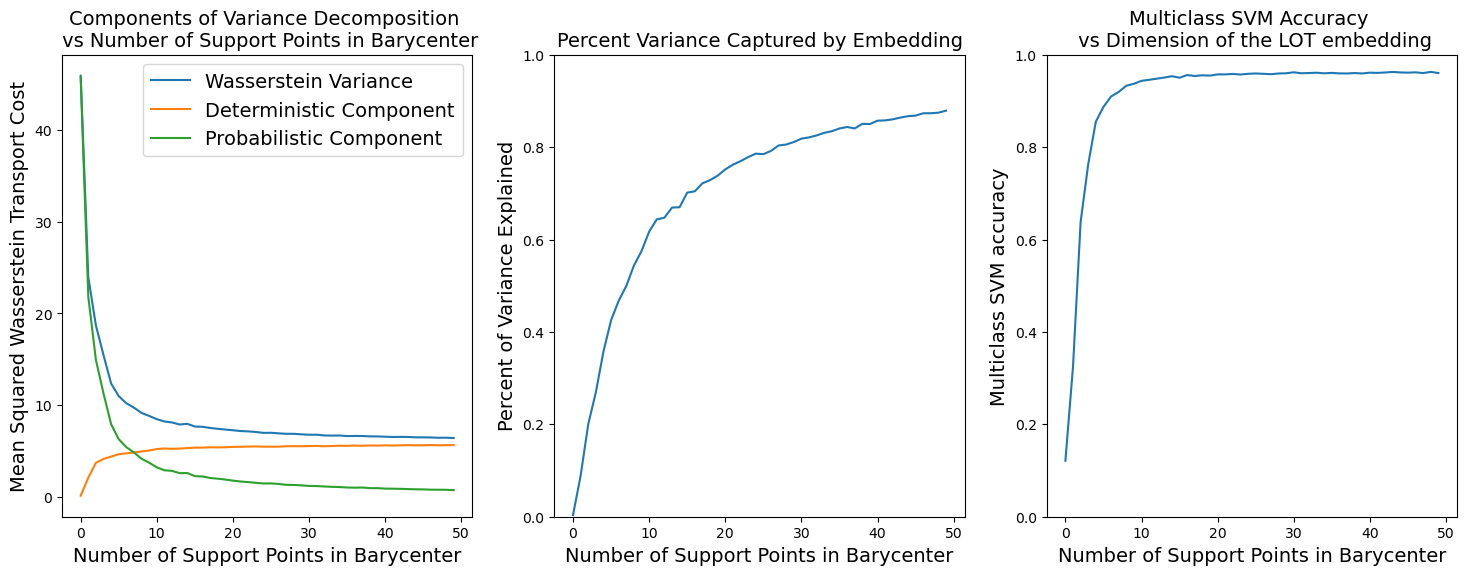

In [16]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.plot(wasserstein_distances)
plt.plot(monge_distances)
plt.plot(proj_distances)
plt.legend(("Wasserstein Variance", "Deterministic Component", "Probabilistic Component"), fontsize=14)
plt.title("Components of Variance Decomposition \n vs Number of Support Points in Barycenter", fontsize=14)
plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
plt.ylabel("Mean Squared Wasserstein Transport Cost", fontsize=14)
# plt.gca().set_aspect(2.18)

plt.subplot(132)
plt.plot(np.array(monge_distances)/np.array(wasserstein_distances))
# plt.plot(np.array(monge_distances)/np.array(wasserstein_distances[-1]), c='black')
plt.title("Percent Variance Captured by Embedding", fontsize=14)
plt.ylim(0,1)
plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
plt.ylabel("Percent of Variance Explained", fontsize=14)
# plt.legend([r"Percent of $Var_W^n$ Variance Explained", r"'Percent' of $Var_W^{50}$ Explained"])
# plt.gca().set_aspect(100)

plt.subplot(133)
plt.plot(acc)
plt.title("Multiclass SVM Accuracy \n vs Dimension of the LOT embedding", fontsize=14)
plt.ylim(0,1)
plt.ylabel("Multiclass SVM accuracy", fontsize=14)
plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
# plt.gca().set_aspect(100)

plt.savefig("MNIST_experiment.png", bbox_inches='tight')

In [17]:
np.array(monge_distances)/np.array(wasserstein_distances)

array([0.00367704, 0.08901472, 0.20042439, 0.26960589, 0.35781531,
       0.42549852, 0.46749206, 0.49955177, 0.54376023, 0.57500789,
       0.61708771, 0.64358588, 0.64725784, 0.66914113, 0.66988266,
       0.70153283, 0.70440654, 0.72167428, 0.72853277, 0.73828757,
       0.75174959, 0.76200007, 0.7695472 , 0.77833969, 0.78586175,
       0.7847803 , 0.79182827, 0.80356932, 0.80562934, 0.81097479,
       0.81834147, 0.8210921 , 0.82530128, 0.83089637, 0.83445515,
       0.84037577, 0.84352288, 0.84051208, 0.85032786, 0.84998023,
       0.85722888, 0.85786065, 0.86018065, 0.86392055, 0.86696718,
       0.86823531, 0.87328234, 0.87335374, 0.87453051, 0.8789227 ])

In [18]:
acc

[0.12110000000000001,
 0.32430000000000003,
 0.6377666666666666,
 0.763,
 0.8550666666666666,
 0.8869999999999999,
 0.9096333333333332,
 0.9194333333333333,
 0.9328666666666667,
 0.9371666666666668,
 0.9434333333333333,
 0.9457000000000001,
 0.9481666666666667,
 0.9506333333333332,
 0.9534666666666667,
 0.9502,
 0.9560000000000001,
 0.954,
 0.9554333333333334,
 0.9548,
 0.9574,
 0.9574333333333334,
 0.9584333333333331,
 0.9571333333333334,
 0.9586333333333332,
 0.9594333333333334,
 0.9586333333333332,
 0.9579000000000001,
 0.9593666666666666,
 0.9598333333333334,
 0.9619666666666665,
 0.9598666666666666,
 0.9603666666666667,
 0.961,
 0.9597333333333333,
 0.9606333333333332,
 0.9596,
 0.9593666666666666,
 0.9603666666666667,
 0.9593999999999999,
 0.9611666666666668,
 0.9606999999999999,
 0.9615333333333332,
 0.9627333333333332,
 0.9616333333333333,
 0.9612333333333334,
 0.9618666666666666,
 0.9602999999999999,
 0.9628333333333334,
 0.9603666666666666]